## Import Libraries

In [21]:
import os
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2

## Mount Google Drive

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Display an image to test if the mount is successful

In [23]:
dataset_path = "/content/drive/MyDrive/datasets/group4"
image_dir = os.path.join(dataset_path, "images")
label_dir = os.path.join(dataset_path, "labels")

In [24]:
def displayImage(image_path):
  # Path to your image file in Google Drive
  image = Image.open(image_path)

  # Display the image using matplotlib
  plt.imshow(image)
  plt.axis('off')  # Hide axes for cleaner display
  plt.show()

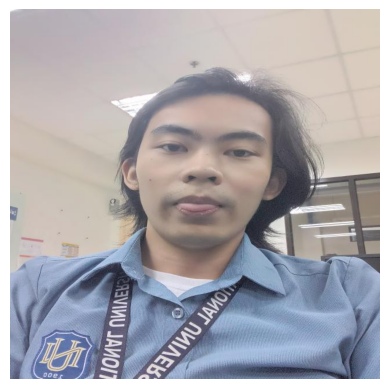

In [25]:
displayImage('/content/drive/MyDrive/datasets/group4/images/20241010_155112_jpg.rf.0cea7ce11d3777a350be9bfc11e05177.jpg')

## Check if GPU is used

In [26]:
# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU available.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Define the image size

In [27]:
SIZE = 256
image_size = (SIZE, SIZE)

In [28]:
X = []
y_class = []
y_bbox = []
class_ids = set()

## Load the images and annotations

In [29]:
for filename in os.listdir(image_dir):
    if filename.endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

        if not os.path.exists(label_path):
            print(f"Warning: Label file not found for {filename}. Skipping this image.")
            continue  # Skip to the next image

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        img = img / 255.0

        # Load annotation
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls = int(parts[0])
            bbox = list(map(float, parts[1:]))

            X.append(img)
            y_class.append(cls)
            y_bbox.append(bbox)
            class_ids.add(cls)

X = np.array(X, dtype=np.float32)

In [30]:
# Map class IDs to indices
class_ids = sorted(list(class_ids))
class_to_idx = {cls: idx for idx, cls in enumerate(class_ids)}
num_classes = len(class_ids)

# # One-hot encode class labels
y_class = [class_to_idx[c] for c in y_class]
y_class = to_categorical(y_class, num_classes=num_classes)

y_bbox = np.array(y_bbox, dtype=np.float32)

## Split the dataset

In [31]:
X_train, X_test, y_cls_train, y_cls_test, y_bbox_train, y_bbox_test = train_test_split(X, y_class, y_bbox, test_size=0.2, random_state=42)

## Build the Convolutional Neural Network

In [32]:
input_layer = layers.Input(shape=(SIZE, SIZE, 3))

x = layers.Conv2D(32, (3,3), activation='relu')(input_layer)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Output 1: class probabilities
class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)

# Output 2: bounding box (x_center, y_center, width, height)
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

model = models.Model(inputs=input_layer, outputs=[class_output, bbox_output])
model.compile(
    optimizer='adam',
    loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
    metrics={'class_output': 'accuracy'}
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 254, 254,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 127, 127,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 62, 62,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 246016)    │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │ 31,490,176 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 2)         │        258 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │        516 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,510,342 (120.20 MB)

 Trainable params: 31,510,342 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    X_train,
    {'class_output': y_cls_train, 'bbox_output': y_bbox_train},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step - bbox_output_loss: 0.0997 - class_output_accuracy: 0.6089 - class_output_loss: 1.3186 - loss: 1.4650 - val_bbox_output_loss: 0.1141 - val_class_output_accuracy: 0.4375 - val_class_output_loss: 5.9106 - val_loss: 6.0247
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - bbox_output_loss: 0.1028 - class_output_accuracy: 0.8209 - class_output_loss: 1.6465 - loss: 1.7812 - val_bbox_output_loss: 0.0796 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0019 - val_loss: 0.0816
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - bbox_output_loss: 0.0634 - class_output_accuracy: 1.0000 - class_output_loss: 8.5515e-04 - loss: 0.0647 - val_bbox_output_loss: 0.0288 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0085 - val_loss: 0.0373
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - bbox_output_loss: 0.0194 - class_output_accuracy: 1.0000 - class_output_loss: 0.0014 - loss: 0.0208 - val_bbox_output_loss: 0.0124 - val_

## Evaluate the model

In [34]:
model.evaluate(X_test, {'class_output': y_cls_test, 'bbox_output': y_bbox_test})

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - bbox_output_loss: 0.0041 - class_output_accuracy: 1.0000 - class_output_loss: 1.3203e-04 - loss: 0.0036


[0.0038257709238678217, 0.00010571498569333926, 0.004735142923891544, 1.0]

## Test the model using the test set

In [35]:
# Predict on the test set
y_pred = model.predict(X_test)

# Separate class and bounding box predictions
y_cls_pred = y_pred[0]  # The class prediction (probabilities)
y_bbox_pred = y_pred[1]  # The bounding box prediction (x_center, y_center, width, height)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


In [36]:
print(y_pred[0])

[[9.99869466e-01 1.30531975e-04]
 [9.99982238e-01 1.77620987e-05]
 [9.99929190e-01 7.08643493e-05]
 [1.33133790e-11 1.00000000e+00]
 [1.00000000e+00 3.38953532e-09]
 [4.44448089e-11 1.00000000e+00]
 [9.99992967e-01 7.06590890e-06]
 [9.41331110e-11 1.00000000e+00]
 [1.50388625e-11 1.00000000e+00]
 [9.96706069e-01 3.29395127e-03]
 [9.99797523e-01 2.02513154e-04]
 [7.45057627e-11 1.00000000e+00]
 [3.26339303e-12 1.00000000e+00]
 [9.98389125e-01 1.61086116e-03]
 [1.04340182e-11 1.00000000e+00]
 [9.01526701e-11 1.00000000e+00]
 [9.99990940e-01 9.02126249e-06]
 [2.11187023e-11 1.00000000e+00]
 [1.00000000e+00 6.10269391e-09]
 [1.00000000e+00 5.47712231e-09]
 [4.88427840e-11 1.00000000e+00]
 [9.99996781e-01 3.26729787e-06]
 [3.59570793e-12 1.00000000e+00]
 [1.00000000e+00 3.36678418e-09]
 [9.99992967e-01 7.04903505e-06]
 [9.99474823e-01 5.25200507e-04]
 [1.00000000e+00 2.76415846e-09]
 [9.99980688e-01 1.92882671e-05]
 [4.53823021e-11 1.00000000e+00]
 [3.52302801e-12 1.00000000e+00]
 [9.999971

In [37]:
print(y_pred[1])

[[0.48141956 0.49098924 0.5957227  0.57781714]
 [0.48835456 0.4190632  0.51595074 0.42063576]
 [0.5055078  0.49305147 0.5848043  0.5383737 ]
 [0.49721265 0.5136342  0.5685884  0.47417215]
 [0.39345467 0.5893734  0.6337491  0.61498624]
 [0.52000743 0.5354174  0.51630235 0.48229843]
 [0.5206793  0.43250495 0.616709   0.5759532 ]
 [0.5737508  0.53175586 0.5942806  0.4460264 ]
 [0.49230528 0.5130992  0.5666834  0.48158878]
 [0.5081098  0.53305644 0.6007942  0.5281702 ]
 [0.496567   0.54148906 0.58454496 0.5267597 ]
 [0.5637478  0.5352999  0.5864915  0.4497704 ]
 [0.5295648  0.5153796  0.543011   0.45101067]
 [0.5130896  0.49965966 0.61028147 0.58868605]
 [0.50641036 0.51592284 0.5769465  0.462068  ]
 [0.5731647  0.5311097  0.5951005  0.44571948]
 [0.49406588 0.49751085 0.58566874 0.5274764 ]
 [0.5396089  0.5251008  0.5732346  0.49622133]
 [0.47315595 0.48567045 0.62980866 0.59093916]
 [0.4847661  0.47582704 0.63228106 0.5887395 ]
 [0.53098184 0.5370198  0.5371978  0.48387957]
 [0.46407774 

## Visualize one image prediction

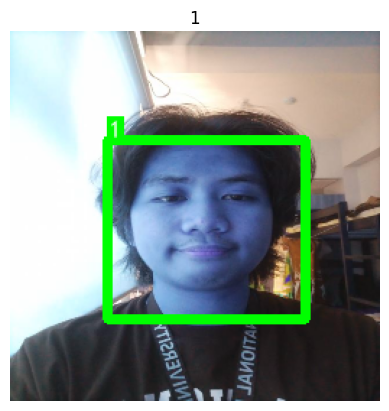

In [38]:
index = 20
img = X_test[20]

# Rescale the bounding box predictions (back to original size)
img_height, img_width, _ = img.shape
predicted_bbox = y_bbox_pred[index]

# Convert normalized bbox to pixel coordinates (0 to img_width / img_height)
x_center = predicted_bbox[0] * img_width
y_center = predicted_bbox[1] * img_height
width = predicted_bbox[2] * img_width
height = predicted_bbox[3] * img_height

# Get the top-left and bottom-right corners of the bounding box
x1 = int(x_center - width / 2)
y1 = int(y_center - height / 2)
x2 = int(x_center + width / 2)
y2 = int(y_center + height / 2)

# Show the predicted class
predicted_class = np.argmax(y_cls_pred, axis=1)
predicted_class_name = class_ids[predicted_class[index]]

img = cv2.resize(img, image_size)
img_display = (img * 255).astype(np.uint8).copy()

color = (0, 255, 0)  # Green box
thickness = 5

# Draw rectangle
cv2.rectangle(img_display, (x1, y1), (x2, y2), color, thickness)

# Choose font
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_thickness = 1

# Get text size to draw background
(text_width, text_height), _ = cv2.getTextSize(str(predicted_class_name), font, font_scale, font_thickness)

# Draw filled rectangle behind text
cv2.rectangle(img_display, (x1, y1 - text_height - 4), (x1 + text_width, y1), color, -1)

# Draw text (white text on top of the box)
cv2.putText(img_display, str(predicted_class_name), (x1, y1 - 2), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

plt.imshow(img_display)
plt.axis("off")
plt.title(predicted_class_name)
plt.show()

## Predict on test data

In [39]:
y_pred = model.predict(X_test)

# Separate the predictions
y_cls_pred = y_pred[0]  # Class probabilities
y_bbox_pred = y_pred[1]  # Bounding box predictions

# Find the predicted class for each sample
predicted_classes = np.argmax(y_cls_pred, axis=1)

# Compare with true class labels (just for class prediction)
true_classes = np.argmax(y_cls_test, axis=1)

# Calculate accuracy (for class prediction)
class_accuracy = np.mean(predicted_classes == true_classes)
print(f"Class prediction accuracy: {class_accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class prediction accuracy: 1.00


## Save the model

In [40]:
model.save('model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpl_rs4fko'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  List[TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)]
Captures:
  138236544378320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236544379856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236544379664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236544380624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236544380432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236544381200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236544381776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236544383312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236544379472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236544382352: T